<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#KOD Z ZAJĘĆ

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

## generating dataset as shown during classes

# Generate the "mouse" dataset
np.random.seed(0)

# Cluster 1
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0], [0.0, 0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# Cluster 2
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0], [0.0, 0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0], [0.0, 0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine data
data_X = np.vstack([data1, data2, data3])

# Fit GMM with 3 clusters
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(data_X)

GaussianMixture(n_components=3, random_state=42)

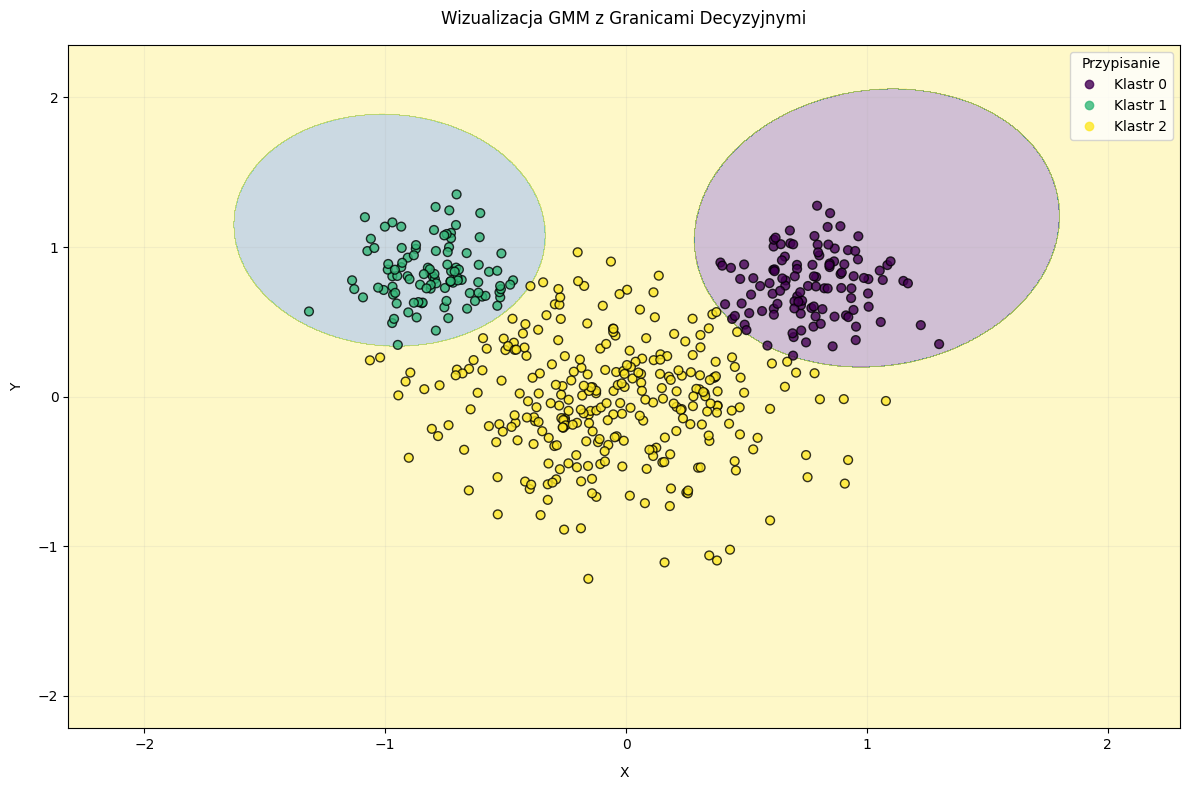

In [16]:
# Konfiguracja przestrzeni wykresu
axis_buffer = 1.0
grid_resolution = 2000
x_limits = (data_X[:, 0].min() - axis_buffer, data_X[:, 0].max() + axis_buffer)
y_limits = (data_X[:, 1].min() - axis_buffer, data_X[:, 1].max() + axis_buffer)

# Generowanie siatki współrzędnych
x_space = np.linspace(*x_limits, num=grid_resolution)
y_space = np.linspace(*y_limits, num=grid_resolution)
X_coords, Y_coords = np.meshgrid(x_space, y_space)

# Transformacja siatki do predykcji
grid_points = np.stack([X_coords.ravel(), Y_coords.ravel()], axis=1)

# Predykcja prawdopodobieństw klastrowania
cluster_probs = gmm.predict_proba(grid_points)
dominant_clusters = cluster_probs.argmax(axis=1)
cluster_matrix = dominant_clusters.reshape(X_coords.shape)

# Przygotowanie wykresu
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Stworzenie mapy kolorów
n_clusters = gmm.n_components
custom_cmap = ListedColormap(plt.cm.viridis.colors[:256:256//n_clusters])

# Wykres konturowy obszarów decyzyjnych
ax.contourf(X_coords, Y_coords, cluster_matrix, cmap=custom_cmap, alpha=0.25)

# Wykres punktów danych
data_clusters = gmm.predict(data_X)
scatter = ax.scatter(
    data_X[:, 0], data_X[:, 1],
    c=data_clusters,
    cmap=custom_cmap,
    edgecolors='k',
    s=40,
    alpha=0.8,
    zorder=2
)

# Konfiguracja legendy
legend_labels = [f'Klastr {i}' for i in range(n_clusters)]
legend = ax.legend(
    handles=scatter.legend_elements()[0],
    labels=legend_labels,
    title="Przypisanie",
    frameon=True,
    framealpha=0.8
)

# Dodatkowe elementy wizualne
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_title('Wizualizacja GMM z Granicami Decyzyjnymi', pad=15)
ax.set_xlabel('X', labelpad=10)
ax.set_ylabel('Y', labelpad=10)
ax.grid(alpha=0.15)

plt.tight_layout()
plt.show()

ODPOWIEDŹ NA PYTANIE 1:


Kod tworzy szczegółową siatkę punktów na zadanym obszarze, a następnie dla każdego punktu ustala, do którego klastra najprawdopodobniej należy.

Odpowiedzią na pytanie, czemu żółty obszar zajmuje znacznie więcej miejsca niż zielony czy fioletowy, jest fakt, że algorytm EM zbliża parametry do wartości oryginalnych rozkładów normalnych i wykrywa, że żółty zbiór posiada największą wariancję, co skutkuje przypisaniem do niego punktów odstających.

<ipython-input-22-f4fc12f40362>:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*data[labels == cluster].T,
<ipython-input-22-f4fc12f40362>:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*data[labels == cluster].T,
<ipython-input-22-f4fc12f40362>:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its 

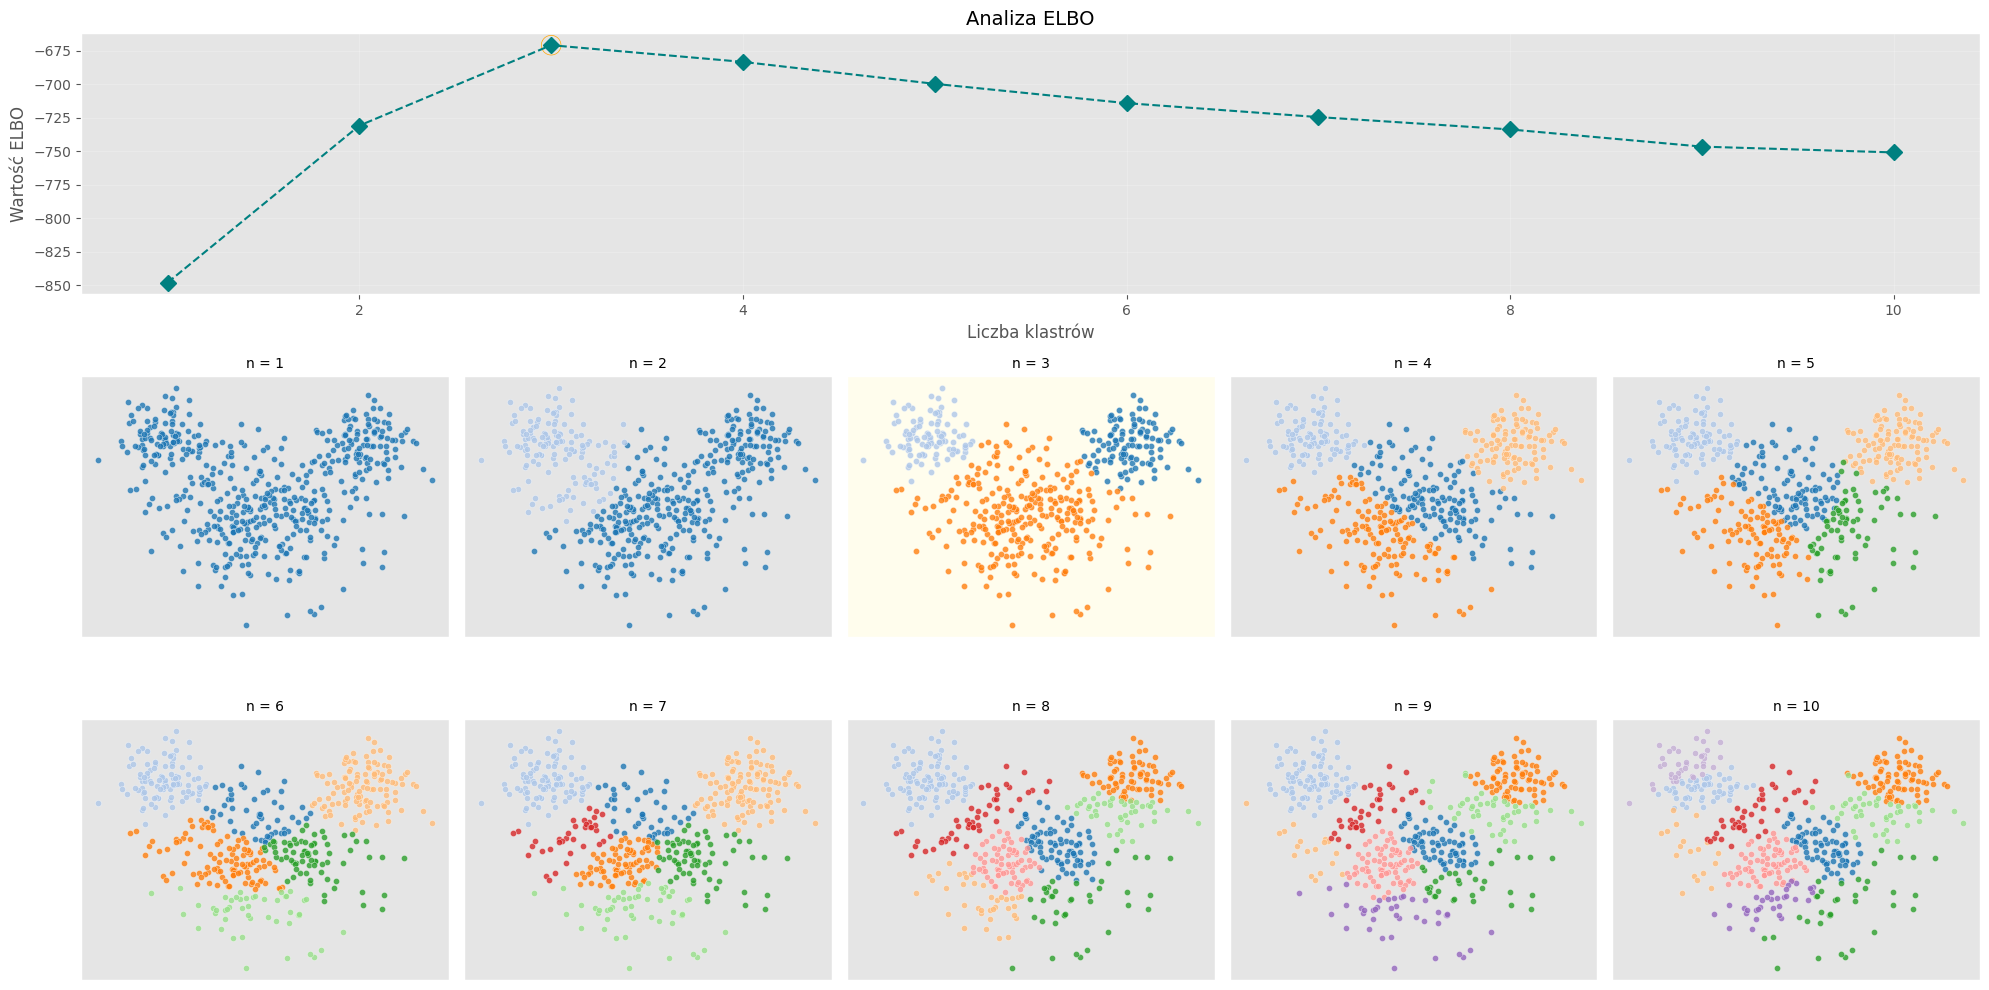

In [22]:
from matplotlib.gridspec import GridSpec

# Parametry konfiguracyjne
max_clusters = 10
data = data_X
cols = 5
rows = 2

# Obliczenia i przygotowanie danych
elbo_scores = []
gmm_models = []

for n in range(1, max_clusters + 1):
    model = GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(data)
    log_likelihood = model.score(data) * len(data)
    n_params = n * (1 + 2 * data.shape[1])
    elbo = log_likelihood - 0.5 * n_params * np.log(len(data))
    elbo_scores.append(elbo)
    gmm_models.append(model)

optimal_n = np.argmax(elbo_scores) + 1

# Konfiguracja wykresu
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(rows + 1, cols, figure=fig)  # +1 dla wykresu ELBO

# Wykres ELBO
ax_main = fig.add_subplot(gs[0, :])
ax_main.plot(range(1, max_clusters+1), elbo_scores, 'D--', color='teal', markersize=8)
ax_main.scatter(optimal_n, elbo_scores[optimal_n-1], s=200, edgecolor='orange', facecolor='none')
ax_main.set_title('Analiza ELBO', fontsize=14)
ax_main.set_xlabel('Liczba klastrów')
ax_main.set_ylabel('Wartość ELBO')
ax_main.grid(alpha=0.2)

# Wizualizacja klastrów
for idx in range(max_clusters):
    row = (idx // cols) + 1  # +1 bo pierwszy wiersz zajęty przez ELBO
    col = idx % cols

    ax = fig.add_subplot(gs[row, col])
    n = idx + 1
    labels = gmm_models[idx].predict(data)

    for cluster in np.unique(labels):
        ax.scatter(*data[labels == cluster].T,
                   c=plt.cm.tab20(cluster),
                   s=20, alpha=0.8,
                   edgecolor='w', linewidth=0.3)

    ax.set_title(f'n = {n}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

    if n == optimal_n:
        ax.patch.set_facecolor('#FFF9C4')
        ax.patch.set_alpha(0.3)

plt.tight_layout()
plt.show()

ODPOWIEDŹ NA PYTANIE 2:

Jeśli nie znamy liczby klastrów z góry, możemy wykorzystać metodę ELBO, która jest ściśle związana z optymalizacją modelu GMM w algorytmie EM. ELBO służy do znalezienia równowagi między dokładnym dopasowaniem modelu do danych a jego złożonością. Przy małych wartościach K model lepiej oddaje strukturę danych, co powoduje wzrost ELBO, natomiast przy zbyt dużej liczbie klastrów wartość ta zaczyna spadać, co wskazuje na nadmierne skomplikowanie modelu. Dlatego wybieramy tę wartość K, która maksymalizuje ELBO, a w naszym przypadku optymalna liczba klastrów wynosi 3.